In [138]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
#!git clone https://github.com/DmitryUlyanov/deep-image-prior
#!mv deep-image-prior/* ./

'\n*Uncomment if running on colab*\nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab\n'

# Import libs

In [139]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import random
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.
torch.manual_seed(2025) # Fixed random seed for reproducibility

In [140]:
# deJPEG
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

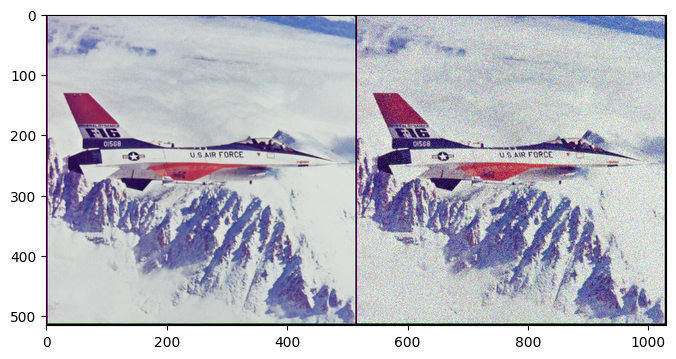

In [141]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)

    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np

    if PLOT:
        plot_image_grid([img_np], 4, 5);

elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [142]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.02 # ADAM

show_every = 1
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5

    net = skip(
                input_depth, 3,
                num_channels_down = [8, 16, 32, 64, 128],
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4],
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32
    figsize = 4


    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


In [143]:
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    if optimizer_type == 'LBFGS':
        print('Starting optimization with LBFGS')
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    else:
        opt_class = {
            'adam': torch.optim.Adam,
            'SGD': torch.optim.SGD,
            'RMSprop': torch.optim.RMSprop,
            'AdamW': torch.optim.AdamW,
            'RAdam': torch.optim.RAdam,
            'Adafactor': torch.optim.Adafactor
        }[optimizer_type]
        optimizer = opt_class(parameters, lr=LR)
        print(f'Starting optimization with {optimizer_type.upper()}')
        for j in range(num_iter):
            optimizer.zero_grad()
            loss = closure()
            optimizer.step()

In [144]:
# index measurements

def l1_l2_ratio_model(model):
    '''
    Param Bias=|\theta|1/|\theta|_2
    大 L1/L2 比值 → 参数更“分散”，偏向稀疏解
    小 L1/L2 → 参数接近均匀分布，偏向小范数解
    '''
    all_params = torch.cat([p.detach().view(-1) for p in model.parameters()])
    l1 = torch.sum(all_params.abs())
    l2 = torch.norm(all_params, p=2)
    return (l1 / (l2 + 1e-12)).item()



def frequency_bias(x):
    """
    Compute Freq Bias=log(1+∣F(fθ​(x))∣), return a scalar float.
    卷积结构天然偏向低频 → log(1+|Fx|) 高，反映网络先拟合平滑部分
    """
    # FFT: shape [B, C, H, W], complex
    Xf = torch.fft.fft2(x, norm='ortho')

    # magnitude
    Xf_mag = torch.abs(Xf)

    # log(1 + |F(x)|)
    log_fx = torch.log1p(Xf_mag)

    # return single scalar (mean over all entries)
    return log_fx.mean().item()


def sensitivity_bias(model, x, num_samples=1):
    """
    Sensitivity / Random Trace/ Random Trace / Jacobian Norm
    Tr(J_x J_X^T)
    E[ || J(x)^T ξ ||^2 ], where ξ ~ N(0, I), same shape as model(x)
    函数输出对输入扰动的敏感程度
    大值 → 输出容易随输入变化 → 函数不平滑
    小值 → 输出平滑，对小扰动不敏感 → 强隐式正则, 说明网络天然正则化
    """
    sensitivity = 0.0
    x = x.clone().detach().requires_grad_(True)
    y = model(x)

    for _ in range(num_samples):
        # ξ MUST have same shape as y
        xi = torch.randn_like(y)
        # compute J^T xi wrt input x
        Jv = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=xi,
            retain_graph=True,
            create_graph=False,
        )[0]
        sensitivity += (Jv.pow(2).sum()).item()

    return sensitivity / num_samples

def jacobian_fro_norm(model, x, max_outputs=256):
    """
    Compute the Frobenius norm of the Jacobian J_x f(x):
        ||J||_F^2 = sum_{i,j} (∂y_i / ∂x_j)^2

    model: neural network f
    x: input tensor with requires_grad=True
    max_outputs: we limit how many output dimensions to avoid explosion
    """

    # Clone input with grad
    x = x.clone().detach().requires_grad_(True)
    y = model(x)
    y_flat = y.view(-1)  # flatten output

    # To reduce computation cost, use only first k outputs
    K = min(max_outputs, y_flat.shape[0])
    fro_sq = 0.0

    for i in range(K):
        grad_i = torch.autograd.grad(
            y_flat[i], x,
            retain_graph=True,
            create_graph=False
        )[0]  # same shape as x

        fro_sq += grad_i.pow(2).sum().item()

    return fro_sq


def jacobian_metrics(model, x, num_trace_samples=1, max_fro_outputs=256):
    """
    Compute both:
        1. Sensitivity Bias (Hutchinson Trace Estimation)
            Tr(JJ^T) ≈ E[ || J^T ξ ||^2 ]
        2. Jacobian Frobenius Norm (partial)
            ||J||_F^2 = sum_{i,j} (∂y_i/∂x_j)^2

    Args:
        model: neural network
        x: input tensor
        num_trace_samples: number of Hutchinson samples
        max_fro_outputs: limit # of outputs to compute Frobenius norm

    Returns:
        sensitivity_trace: float
        frobenius_norm: float
    """

    # Prepare input
    x = x.clone().detach().requires_grad_(True)
    y = model(x)
    y_flat = y.view(-1)

    # ----- 1) Sensitivity (Hutchinson Trace) -----
    sensitivity_trace = 0.0
    for _ in range(num_trace_samples):
        xi = torch.randn_like(y)  # same shape as output
        Jv = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=xi,
            retain_graph=True,
            create_graph=False,
        )[0]
        sensitivity_trace += Jv.pow(2).sum().item()
    sensitivity_trace /= num_trace_samples

    # ----- 2) Frobenius Norm (partial) -----
    fro_sq = 0.0
    K = min(max_fro_outputs, y_flat.shape[0])
    for i in range(K):
        grad_i = torch.autograd.grad(
            outputs=y_flat[i],
            inputs=x,
            retain_graph=True,
            create_graph=False,
        )[0]
        fro_sq += grad_i.pow(2).sum().item()

    return sensitivity_trace, fro_sq



def ntk_spectrum(model, x, n_eig=20):
    """
    Compute top NTK eigenvalues using Jacobian-vector product.
    x: input batch (B,C,H,W)
    大的最大特征值 → 网络对输入变化敏感（容易拟合高频）
    小的最大特征值 → 网络较平滑（偏向低频映射）
    """
    model.eval()
    x = x.requires_grad_(True)
    y = model(x)                     # (B, C, H, W)
    B = y.shape[0]
    # Flatten output per sample
    y = y.view(B, -1)
    # Compute Jv for random v
    eigvals = []
    for _ in range(n_eig):
        v = torch.randn_like(y)
        Jv = torch.autograd.grad(
            outputs=y,
            inputs=list(model.parameters()),
            grad_outputs=v,
            retain_graph=True,
            create_graph=False,
            allow_unused=True
        )

        # Convert (list of tensors) → one big vector
        Jv_flat = torch.cat([g.reshape(-1) for g in Jv if g is not None])

        eigvals.append(Jv_flat.pow(2).sum().item())

    return {"NTK_eigenvalues": sorted(eigvals, reverse=True)}

def measure_biases(model, x, img_out):
    return {
        "param_bias": param_bias(model),
        "ntk": ntk_spectrum(model, x),
        "frequency_bias": frequency_bias(img_out),
        "sensitivity": sensitivity_bias(model, x)
    }
FREQ_PARAM = 1        # every step
FREQ_FREQ_BIAS = 1    # every 5 steps
FREQ_SENS = 1        # every 20 steps
FREQ_NTK = 1        # every 100 steps

# Optimize

In [ ]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import numpy as np
import copy

# Define the list of optimizers to run
OPTIMIZER_LIST = ['SGD', 'LBFGS', 'adam', 'AdamW', 'RAdam', 'Adafactor'] #['SGD', 'LBFGS', 'adam', 'RAdam']#'RMSprop',

# Define a dictionary for learning rates for each optimizer
OPTIMIZER_LRS = {
    'SGD': 3,
    'LBFGS': 2, #2.5 worse
    'adam': 0.001,
    'RMSprop': 0.01,
    'AdamW': 0.005,
    'RAdam': 0.05, # 1.5
    'Adafactor': 0.05
}

results = {}

def run_optimizer(OPTIMIZER_name, current_LR):
    print(f"\n===== Running {OPTIMIZER_name.upper()} with LR={current_LR} for {num_iter} iterations =====")

    # === 重新初始化网络与输入 ===
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

    net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    out_avg = None
    last_net = None
    psrn_noisy_last = 0

    loss_values = []
    psnr_values = []
    psnr_sm_values = []

    metrics_l1_l2 = []
    metric_freq = []
    metric_sens = []
    metric_jf = []
    metric_sens_jf = []
    metric_ntk = []
    finalresult = []
    finalresultsm = []

    i = 0 # This counter is reset for each optimizer run
    def closure():
        nonlocal i, out_avg, psrn_noisy_last, last_net, net_input

        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

        out = net(net_input)

        finalresult.append(out.detach())

        # Smoothing
        if out_avg is None:
            out_avg = out.detach()
        else:
            out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

        finalresultsm.append(out_avg.detach())

        total_loss = mse(out, img_noisy_torch)
        total_loss.backward()
        loss_values.append(total_loss.item())

        psrn_gt = compare_psnr(img_np, out.detach().cpu().numpy()[0])
        psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])
        psnr_values.append(psrn_gt)
        psnr_sm_values.append(psrn_gt_sm)

        # ======================================================
        if i % FREQ_PARAM == 0:
            ratio = l1_l2_ratio_model(net)
            metrics_l1_l2.append((ratio))
            # print(f"L1/L2={ratio:.5f}")
        else:
            metrics_l1_l2.append(ratio[-1])

        # Frequency bias every few steps
        # if i % FREQ_FREQ_BIAS == 0:
        #     freq_val = frequency_bias(out.detach())
        #     metric_freq.append(freq_val)
        #     print(f"log(1+|Fx|)={freq_val:.5f}")
        # else:
        #     metric_freq.append(metric_freq[-1] if len(metric_freq) > 0 else 0)

        # sensitivity
        if i % FREQ_SENS == 0:
            # sens_val = sensitivity_bias(net, net_input_saved)
            # metric_sens.append(sens_val)
            # print(f"Random Trace={sens_val:.5f}")
            # jf_val = jacobian_fro_norm(net, net_input_saved)
            # metric_jf.append(jf_val)
            # print(f"Frobenius Norm={jf_val:.5f}")
            sens_val, fro_val = jacobian_metrics(net, net_input_saved)
            metric_sens.append(sens_val)
            metric_jf.append(fro_val)
            metric_sens_jf.append((sens_val/fro_val))
            print(f"Random Trace={sens_val:.5f}")
            print(f"Frobenius Norm={fro_val:.5f}")
        else:
            metric_sens.append(metric_sens[-1] if len(metric_sens) > 0 else 0)

        # NTK spectrum: only store largest eigenvalue
        if i % FREQ_NTK == 0:
            # nk = ntk_spectrum(net, net_input_saved, n_eig=1)
            # metric_ntk.append(nk)
            net_copy = copy.deepcopy(net)
            x_copy = net_input_saved.clone().detach().requires_grad_(True)
            nk = ntk_spectrum(net_copy, x_copy, n_eig=20)
            metric_ntk.append(nk)

            print(f"NTK={nk}")
        else:
            metric_ntk.append(metric_ntk[-1] if len(metric_ntk) > 0 else 0)

        # Print iteration count as 1-based for user clarity
        print(f"[{OPTIMIZER_name}] Iter {i+1:05d}/{num_iter:05d} | Loss {total_loss.item():.6f} | PSNR_gt {psrn_gt:.2f} | PSNR_gt_sm {psrn_gt_sm:.2f} | L1/L2 {ratio:.5f}")
        i += 1
        return total_loss

    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER_name, p, closure, current_LR, num_iter) # Use current_LR here

    return {
        'loss': loss_values,
        'psnr': psnr_values,
        'psnr_sm': psnr_sm_values,
        'ratio': metrics_l1_l2,
        'freq': metric_freq,
        'sens': metric_sens,
        'jf': metric_jf,
        'sens_jf': metric_sens_jf,
        'ntk': metric_ntk,
        'finalresult': finalresult,
        'finalresultsm': finalresultsm
    }


# ========== main loop for every optimizer ========== # Iterate using OPTIMIZER_LIST and OPTIMIZER_LRS
for OPTIMIZER_name in OPTIMIZER_LIST:
    # fix random input
    torch.manual_seed(2025)
    np.random.seed(2025)
    random.seed(2025)
    lr_for_optimizer = OPTIMIZER_LRS.get(OPTIMIZER_name, LR) # Get LR from dict, fallback to global LR
    results[OPTIMIZER_name] = run_optimizer(OPTIMIZER_name, lr_for_optimizer)


# ========== plot ========== # Plotting logic remains the same, as it depends on the 'results' dictionary.
plt.figure(figsize=(18, 5))

# ---- (1) Loss ----
plt.subplot(1, 3, 1)
for opt_name, data in results.items():
    plt.plot(data['loss'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# ---- (2) PSNR (GT) ----
plt.subplot(1, 3, 2)
for opt_name, data in results.items():
    plt.plot(data['psnr'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR (GT)')
plt.legend()
plt.grid(True)

# ---- (3) PSNR (Smoothed) ----
plt.subplot(1, 3, 3)
for opt_name, data in results.items():
    plt.plot(data['psnr_sm'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR (Smoothed)')
plt.legend()
plt.grid(True)

plt.suptitle('Image Denoising Results under Different Optimizers (Each from Scratch)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


iters = np.arange(num_iter)

def plot_metric(metric_name):
    plt.figure(figsize=(10,5))
    for opt_name in results:
        if metric_name == 'ntk':
          plt.subplot(1, 3, 1)
          ntk_vals = [d['NTK_eigenvalues'][0] for d in results[opt_name]['ntk']]
          plt.plot(ntk_vals, label=opt_name)
          plt.title([metric_name, 'eigenvalues 1'])
          plt.xlabel("Iteration")
          plt.grid(True)
          plt.legend()
          plt.subplot(1, 3, 2)
          ntk_vals1_5 = [d['NTK_eigenvalues'][0]/d['NTK_eigenvalues'][4] for d in results[opt_name]['ntk']]
          plt.plot(ntk_vals1_5, label=opt_name)
          plt.title([metric_name, 'eigenvalues 1/5'])
          plt.xlabel("Iteration")
          plt.grid(True)
          plt.legend()
          plt.subplot(1, 3, 3)
          ntk_vals1_20 = [d['NTK_eigenvalues'][0]/d['NTK_eigenvalues'][19] for d in results[opt_name]['ntk']]
          plt.plot(ntk_vals1_20, label=opt_name)
          plt.title([metric_name, 'eigenvalues 1/20'])
          plt.xlabel("Iteration")
          plt.grid(True)
          plt.legend()
        else:
          plt.plot(results[opt_name][metric_name], label=opt_name)
          plt.title(metric_name)
    plt.xlabel("Iteration")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_metric('ratio')
# plot_metric('freq')
plot_metric('sens')
plot_metric('jf')
plot_metric('sens_jf')
plot_metric('ntk')


===== Running SGD with LR=3 for 3000 iterations =====
Starting optimization with SGD
Random Trace=325908288.00000
Frobenius Norm=166057.12930
NTK={'NTK_eigenvalues': [280006.15625, 262259.96875, 223313.96875, 201181.171875, 160339.640625, 149309.484375, 110658.796875, 95543.109375, 81860.8984375, 70580.6328125, 70518.5625, 70196.5078125, 45168.32421875, 41697.80859375, 36079.25, 36007.66796875, 32651.0390625, 24447.95703125, 11836.537109375, 8301.0625]}
[SGD] Iter 00001/03000 | Loss 0.089646 | PSNR_gt 10.91 | PSNR_gt_sm 10.91 | L1/L2 604.24591
Random Trace=113185352.00000
Frobenius Norm=49951.13647
NTK={'NTK_eigenvalues': [333920.8125, 311082.0625, 284483.0, 278497.8125, 253085.25, 211594.546875, 186615.53125, 179950.453125, 176886.125, 172073.59375, 166730.671875, 136154.390625, 129537.640625, 110404.0, 74395.5859375, 63978.36328125, 58865.21875, 35222.1328125, 32323.5859375, 20452.423828125]}
[SGD] Iter 00002/03000 | Loss 0.049808 | PSNR_gt 13.89 | PSNR_gt_sm 10.98 | L1/L2 604.76544

In [ ]:
# error = []
# for img_idx in range(len(results['adam']['finalresult'])):
#     x1 = results['adam']['finalresult'][img_idx]
#     x2 = results['AdamW']['finalresult'][img_idx]

#     # 假设 frequency_bias 返回标量 float
#     freq_val1 = frequency_bias(x1.detach())
#     freq_val2 = frequency_bias(x2.detach())

#     ferror = abs(freq_val1 - freq_val2)  # 标量
#     error.append(ferror)

# # 绘制曲线
# plt.figure(figsize=(10, 5))
# plt.plot(range(len(error)), error, marker='o', linestyle='-')
# plt.xlabel("Image Index")
# plt.ylabel("Frequency-domain Error")
# plt.title("|log(1+|F(fθ(x_adam))|) - log(1+|F(fθ(x_AdamW))|)|")
# plt.grid(True)
# plt.show()

# def plot_frequency_error(results1, results2, name1="Optimizer1", name2="Optimizer2", frequency_bias_func=None):
#     error = []

#     for img_idx in range(len(results1)):
#         x1 = results1[img_idx].detach()
#         x2 = results2[img_idx].detach()
#         freq_val1 = frequency_bias_func(x1)
#         freq_val2 = frequency_bias_func(x2)
#         ferror = abs(freq_val1 - freq_val2)
#         error.append(ferror)
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(len(error)), error, marker='o', linestyle='-', label=f"{name1} vs {name2}")
#     plt.xlabel("Image Index")
#     plt.ylabel("Frequency-domain Error")
#     plt.title(f"|log(1+|F(fθ({name1}))|) - log(1+|F(fθ({name2}))|)|")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# #'SGD', 'LBFGS', 'adam', 'AdamW', 'RAdam', 'Adafactor'
# plot_frequency_error(
#     results['adam']['finalresult'],
#     results['AdamW']['finalresult'],
#     name1="Adam",
#     name2="AdamW",
#     frequency_bias_func=frequency_bias
# )
# plot_frequency_error(
#     results['adam']['finalresult'],
#     results['SGD']['finalresult'],
#     name1="Adam",
#     name2="SGD",
#     frequency_bias_func=frequency_bias
# )

import itertools

def plot_all_pairs_frequency_error(results, optimizer_names, frequency_bias_func):
    """
    绘制所有优化器两两组合的频域误差曲线。

    Args:
        results: dict, 每个 optimizer 的结果，如 results['adam']['finalresult']
        optimizer_names: list of str, optimizer 名称
        frequency_bias_func: function, 输入 torch.Tensor 返回标量 float
    """
    pairs = list(itertools.combinations(optimizer_names, 2))

    for name1, name2 in pairs:
        error = []
        res1 = results[name1]['finalresult']
        res2 = results[name2]['finalresult']
        for img_idx in range(len(res1)):
            x1 = res1[img_idx].detach()
            x2 = res2[img_idx].detach()
            freq_val1 = frequency_bias_func(x1)
            freq_val2 = frequency_bias_func(x2)
            ferror = abs(freq_val1 - freq_val2)
            error.append(ferror)
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(error)), error, marker='o', linestyle='-', label=f"{name1} vs {name2}")
        plt.xlabel("Image Index")
        plt.ylabel("Frequency-domain Error")
        plt.title(f"|log(1+|F(fθ({name1}))|) - log(1+|F(fθ({name2}))|)|")
        plt.legend()
        plt.grid(True)
        plt.show()
optimizer_list = ['SGD', 'LBFGS', 'adam', 'AdamW', 'RAdam', 'Adafactor']
plot_all_pairs_frequency_error(results, optimizer_list, frequency_bias)

In [ ]:
def plot_vs_adam_frequency_error(results, other_optimizers, frequency_bias_func):
    """
    绘制 Adam 与其他优化器的频域误差曲线。

    Args:
        results: dict, 每个 optimizer 的结果，如 results['adam']['finalresult']
        other_optimizers: list of str, 其他 optimizer 名称
        frequency_bias_func: function, 输入 torch.Tensor 返回标量 float
    """
    for name in other_optimizers:
        error = []
        res1 = results['adam']['finalresult']
        res2 = results[name]['finalresult']
        for img_idx in range(len(res1)):
            x1 = res1[img_idx].detach()
            x2 = res2[img_idx].detach()
            freq_val1 = frequency_bias_func(x1)
            freq_val2 = frequency_bias_func(x2)
            ferror = abs(freq_val1 - freq_val2)
            error.append(ferror)
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(error)), error, marker='o', linestyle='-', label=f"Adam vs {name}")
        plt.xlabel("Image Index")
        plt.ylabel("Frequency-domain Error")
        plt.title(f"|log(1+|F(fθ(Adam))|) - log(1+|F(fθ({name}))|)|")
        plt.legend()
        plt.grid(True)
        plt.show()
other_optimizers = ['SGD', 'LBFGS', 'AdamW', 'RAdam', 'Adafactor']
plot_vs_adam_frequency_error(results, other_optimizers, frequency_bias)


In [ ]:
markers = {
    'adam': 'o',
    'SGD': 's',
    # 'RMSprop': 'd',
    'AdamW': '*',
    'RAdam': 'x',
    'Adafactor': '^',
    'LBFGS': 'P'
}
plt.figure(figsize=(100, 30))
for opt_name, data in results.items():
    plt.plot(data['loss'], data['psnr'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})', marker=markers[opt_name], linestyle=' ')
plt.xlabel('Loss')
plt.ylabel('PSNR (GT)')
plt.title('PSNR vs. Loss Curve for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()